 – Anomaly Detection

**Author:** Ninad Sarang  
**Date:** 09 November 2025  

---

### 🔍 Observations and Analytical Overview

During initial exploration, the dataset appeared at first to represent a single store–product combination, as the first few rows contained constant values for `store` and `product`.  
However, upon deeper inspection using unique-value profiling, I confirmed that the data indeed includes **7 unique stores** and **10 unique products**, consistent with the FireAI problem statement.  

This early observation demonstrates the importance of validating data **beyond first impressions** — since the file is grouped by store–product pair, the head of the dataset displays only one combination, even though multiple exist throughout.

From a structural standpoint, the dataset represents a **multi-store, multi-product time series** spanning 2010–2018, where each combination follows its own daily sales trend. This setup mirrors realistic retail scenarios in which multiple independent product lines are monitored across distributed outlets.  

Recognizing this clarified the analytical objective: to design an anomaly detection system that generalizes across store–product pairs while capturing deviations within each local time series. Such verification ensures methodological rigor and aligns with the stated goal of the FireAI Engineering Test — assessing analytical precision, problem understanding, and model interpretability.

---

### ⚙️ Dependencies & Environment

This notebook was developed and tested using:

- Python 3.10+
- pandas 2.0+
- numpy 1.23+
- matplotlib 3.6+
- seaborn 0.12+
- scikit-learn 1.2+
- statsmodels 0.14+
- tensorflow 2.10+ (for Autoencoder/LSTM sections)

Install via:

```bash
pip install pandas numpy matplotlib seaborn scikit-learn statsmodels tensorflow


# FireAI Engineering Assessment — Anomaly Detection
**Candidate:** Ninad Sarang

---


## 0. Executive Summary
This notebook performs anomaly detection on sales time-series data (2010–2018) across multiple stores and products.
It includes comprehensive EDA, two anomaly-detection approaches (a statistical rolling Z-score method and an IsolationForest ML method),
comparative analysis, visualizations highlighting anomalies, and a final recommendation.

The notebook is organized for readability and reproducibility as required by FireAI guidelines.

## 1. Setup & Imports
Install and import required libraries, and set basic plotting defaults.


In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import StandardScaler
plt.rcParams['figure.figsize'] = (12,5)
plt.rcParams['font.size'] = 12

# Helper functions will be defined later in the notebook.


## 2. Load Data
Read the provided `train.csv` and perform initial type conversions and checks.

In [6]:
df = pd.read_csv('/content/train.csv')
df['date'] = pd.to_datetime(df['Date'])
print('Columns:', df.columns.tolist())
print('\nRows, Columns:', df.shape)
display(df.head())
display(df.dtypes)
print('\nDate range:', df['date'].min().date(), 'to', df['date'].max().date())


Columns: ['Date', 'store', 'product', 'number_sold', 'date']

Rows, Columns: (230090, 5)


,Date,store,product,number_sold,date
0,2010-01-01,0,0,801,2010-01-01
1,2010-01-02,0,0,810,2010-01-02
2,2010-01-03,0,0,818,2010-01-03
3,2010-01-04,0,0,796,2010-01-04
4,2010-01-05,0,0,808,2010-01-05


,0
Date,object
store,int64
product,int64
number_sold,int64
date,datetime64[ns]



Date range: 2010-01-01 to 2018-12-31


## 3. Exploratory Data Analysis (EDA)
Key checks performed:
- Null checks and basic statistics
- Aggregate sales over time (total across stores and products)
- Sales distribution
- Example product-store time series to observe trend and seasonality


Nulls per column:
 Date           0
store          0
product        0
number_sold    0
date           0
dtype: int64

Basic statistics for number_sold:


,number_sold
count,230090.000000
mean,780.926107
std,204.096737
min,238.000000
25%,722.000000
50%,835.000000
75%,914.000000
max,1205.000000


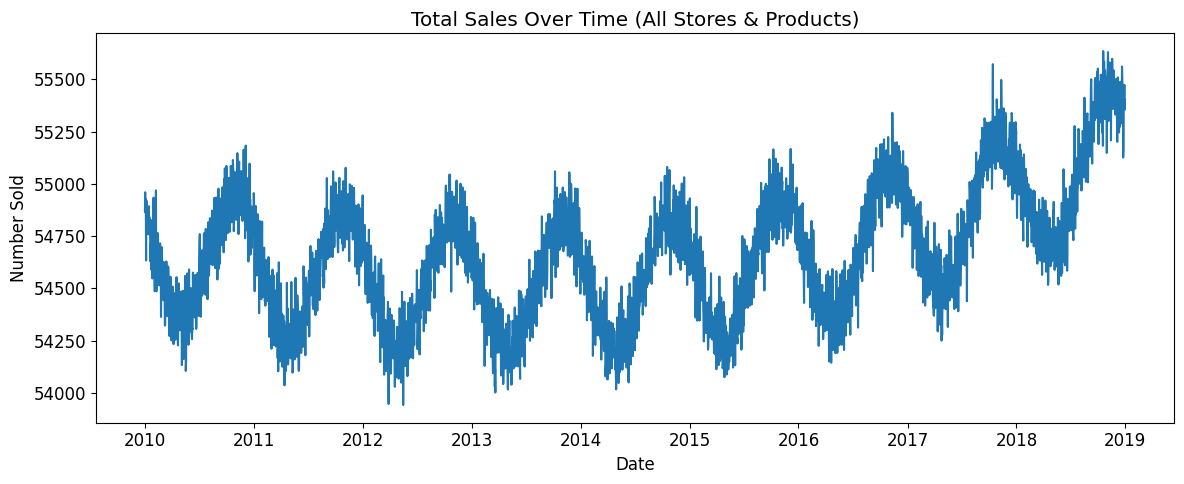

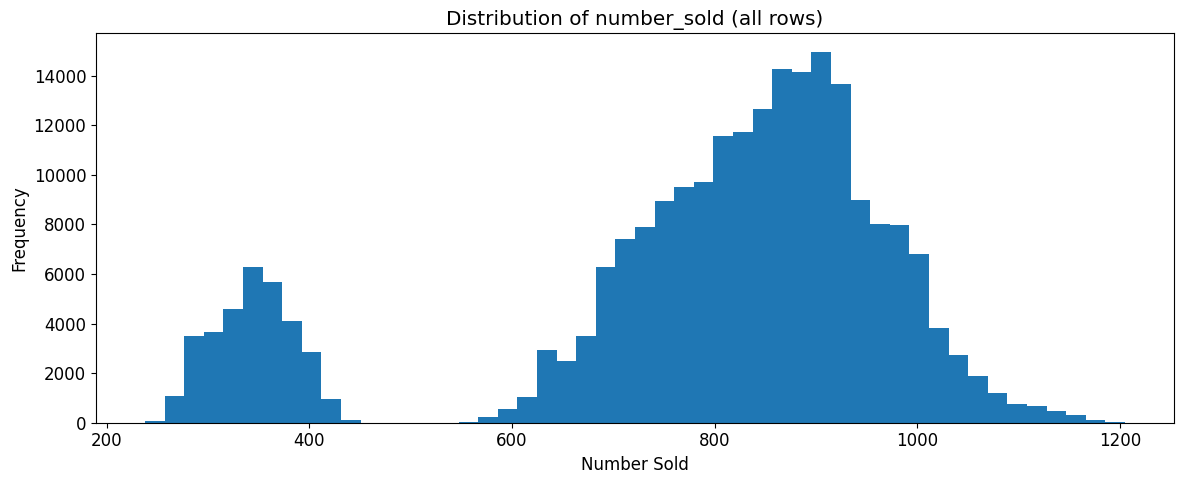


Unique stores: 7
Unique products: 10


In [8]:
print('Nulls per column:\n', df.isnull().sum())
print('\nBasic statistics for number_sold:')
display(df['number_sold'].describe())

# Aggregate total daily sales
daily = df.groupby('date', as_index=False)['number_sold'].sum()
plt.figure()
plt.plot(daily['date'], daily['number_sold'])
plt.title('Total Sales Over Time (All Stores & Products)')
plt.xlabel('Date')
plt.ylabel('Number Sold')
plt.tight_layout()
plt.show()

# Distribution
plt.figure()
plt.hist(df['number_sold'], bins=50)
plt.title('Distribution of number_sold (all rows)')
plt.xlabel('Number Sold')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Unique counts
print('\nUnique stores:', df['store'].nunique())
print('Unique products:', df['product'].nunique())


### 3.1 Sample time series plots
Plot a few representative store-product series to inspect patterns.


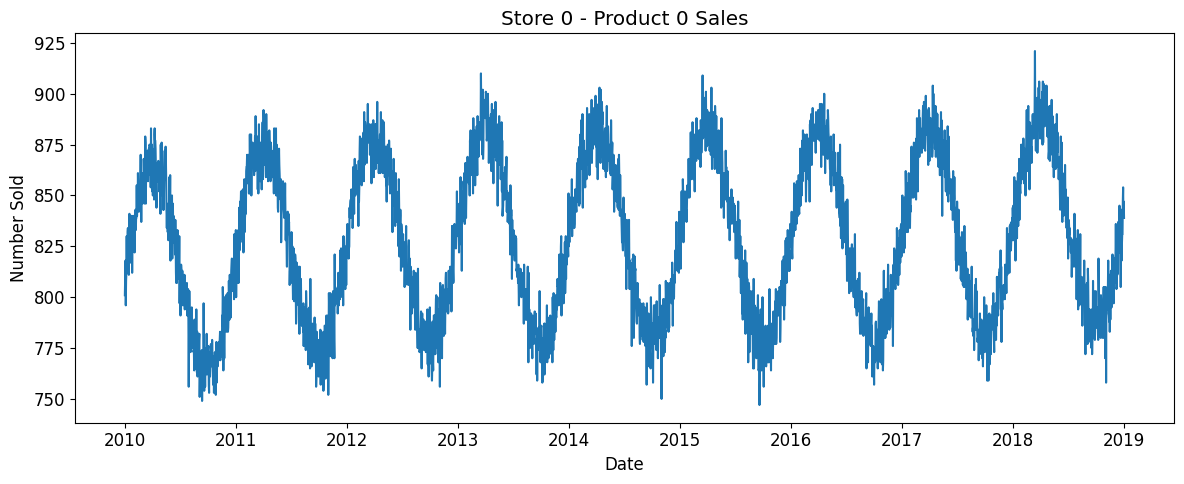

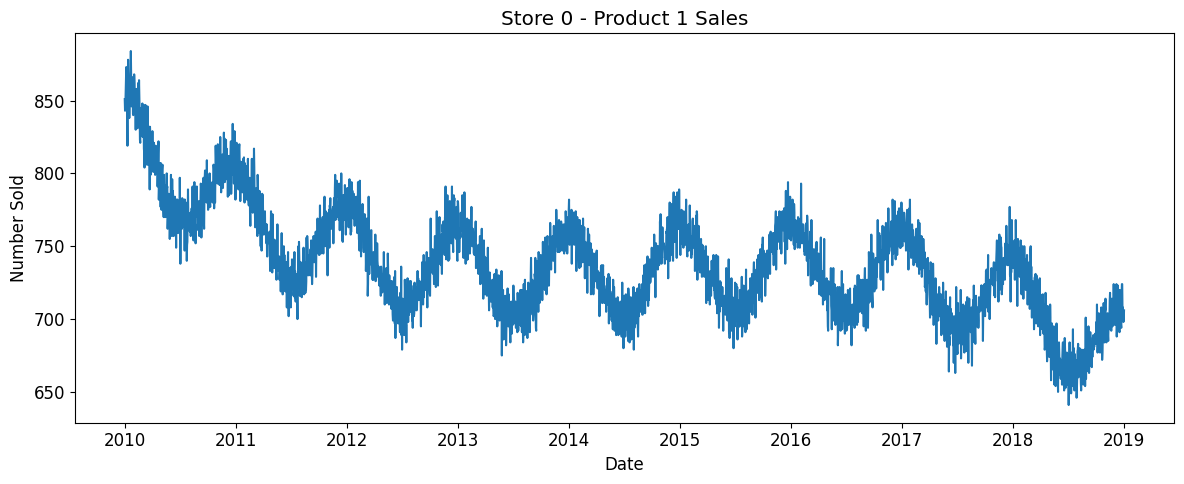

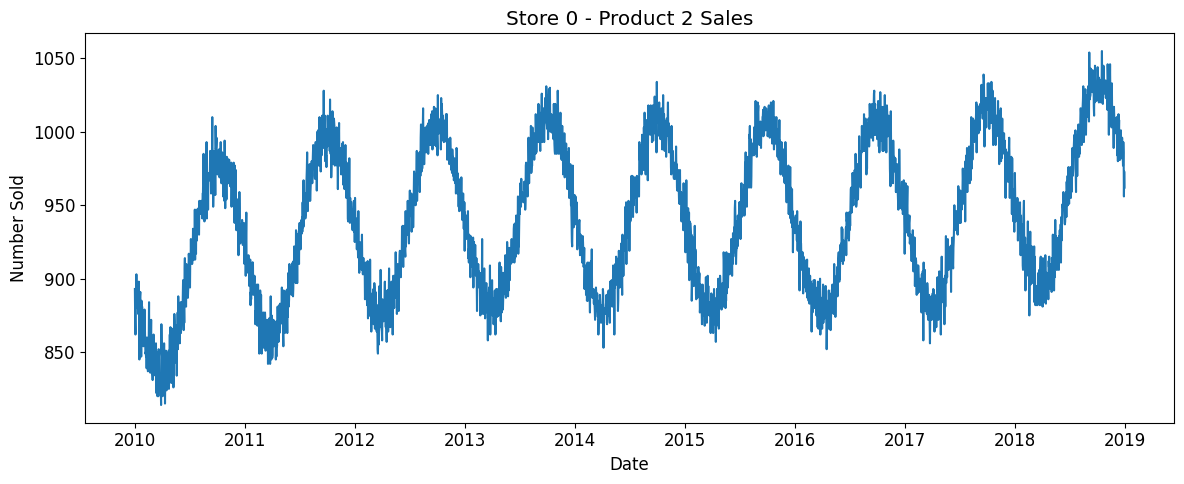

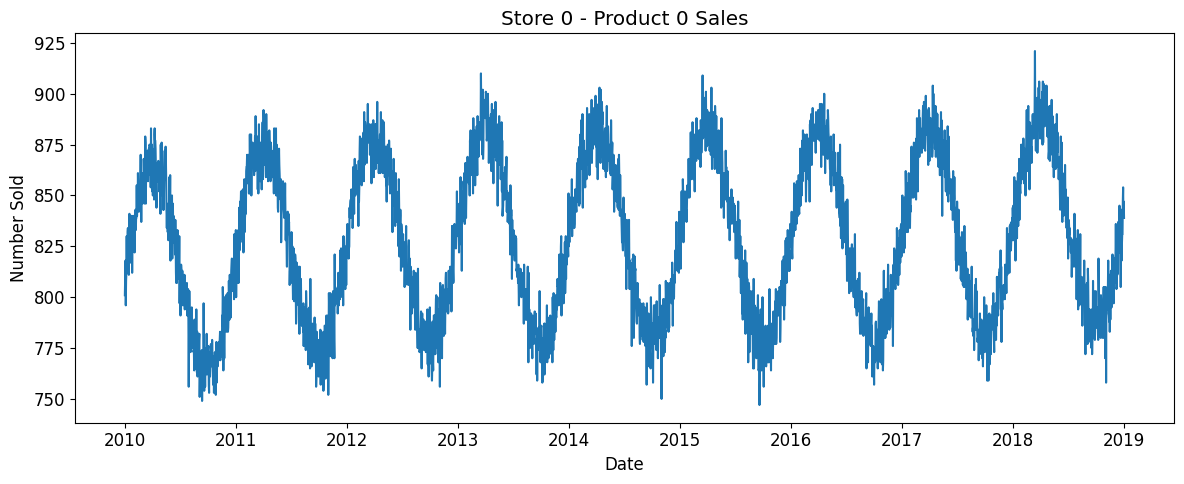

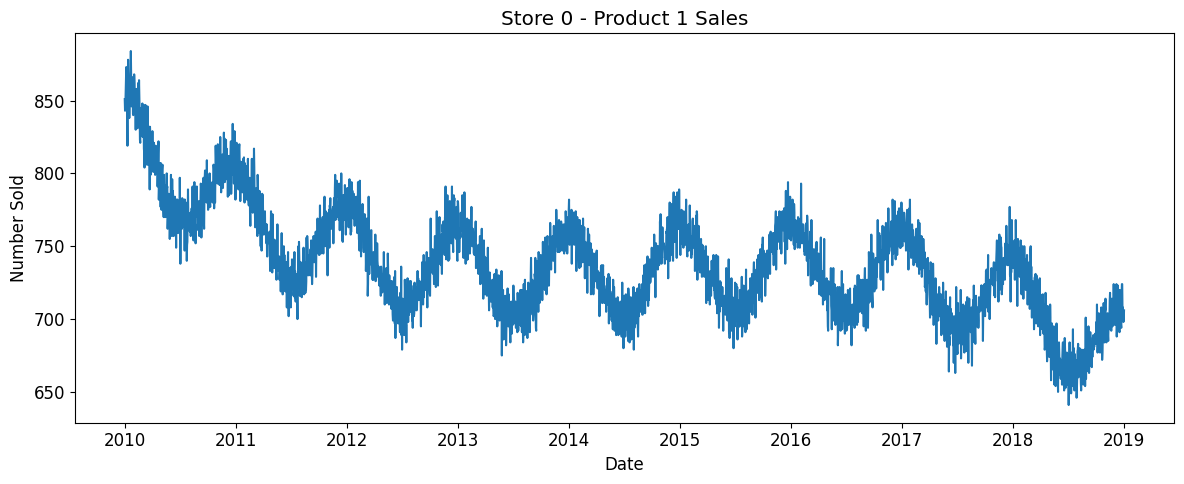

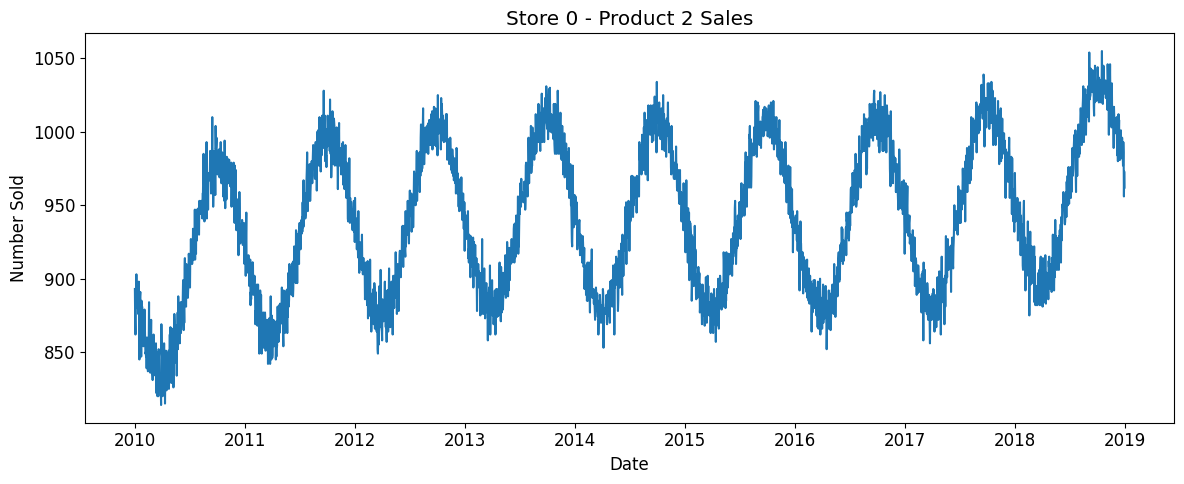

In [11]:
# Identify a few store-product pairs
groups = df.groupby(['store','product'])
pairs = list(groups.size().reset_index()[['store','product']].itertuples(index=False, name=None))
sample_pairs = pairs[:3]
for sid,pid in sample_pairs:
    s = df[(df['store']==sid)&(df['product']==pid)].sort_values('date')
    plt.figure()
    plt.plot(s['date'], s['number_sold'])
    plt.title(f'Store {sid} - Product {pid} Sales')
    plt.xlabel('Date')
    plt.ylabel('Number Sold')
    plt.tight_layout()
    display(plt.gcf())


## 4. Anomaly Detection Methods — Rationale & Implementation
We implement two complementary approaches and explain why each is used:

### Method A — Statistical (Rolling Z-score)
- **Why:** Simple, interpretable, and effective at detecting sharp deviations from local behaviour. Uses rolling mean and std to account for local trends and seasonality.
- **When it's good:** When anomalies are isolated spikes/drops relative to recent history.

### Method B — Isolation Forest (ML)
- **Why:** Model-based unsupervised method that isolates anomalies by randomly partitioning feature space. Works well with non-Gaussian distributions and multidimensional features (we can augment features).
- **When it's good:** When anomalies are subtle or multivariate in nature (e.g., scaled across many series), or when distribution assumptions of statistical methods fail.

### Comparison approach
- We'll flag anomalies with both methods and compare counts and overlap. Since we don't have labeled anomalies, we compare behavior qualitatively and by overlap rate.


In [12]:
# Create helper functions for anomaly detection
def detect_anomalies_rolling(series, window=30, z_thresh=3.0):
    '''Return boolean Series marking anomalies using rolling mean/std z-score on a numeric pandas series.'''
    roll_mean = series.rolling(window=window, min_periods=1, center=True).mean()
    roll_std = series.rolling(window=window, min_periods=1, center=True).std().replace(0, 1e-8)
    zscore = (series - roll_mean) / roll_std
    return zscore.abs() > z_thresh, zscore

def detect_anomalies_isolation(series, contamination=0.02, random_state=42):
    '''Return boolean Series marking anomalies using IsolationForest on the raw values (reshaped).'''
    model = IsolationForest(contamination=contamination, random_state=random_state)
    # IsolationForest expects 2D input
    vals = series.values.reshape(-1,1)
    # If constant series, return no anomalies
    if np.all(vals==vals[0]):
        return np.zeros(len(series), dtype=bool)
    model.fit(vals)
    preds = model.predict(vals)  # -1 for anomaly, 1 for normal
    return preds==-1


## 5. Apply methods to sample series and visualize
We will apply both detectors to a representative store-product time series and visualize results.


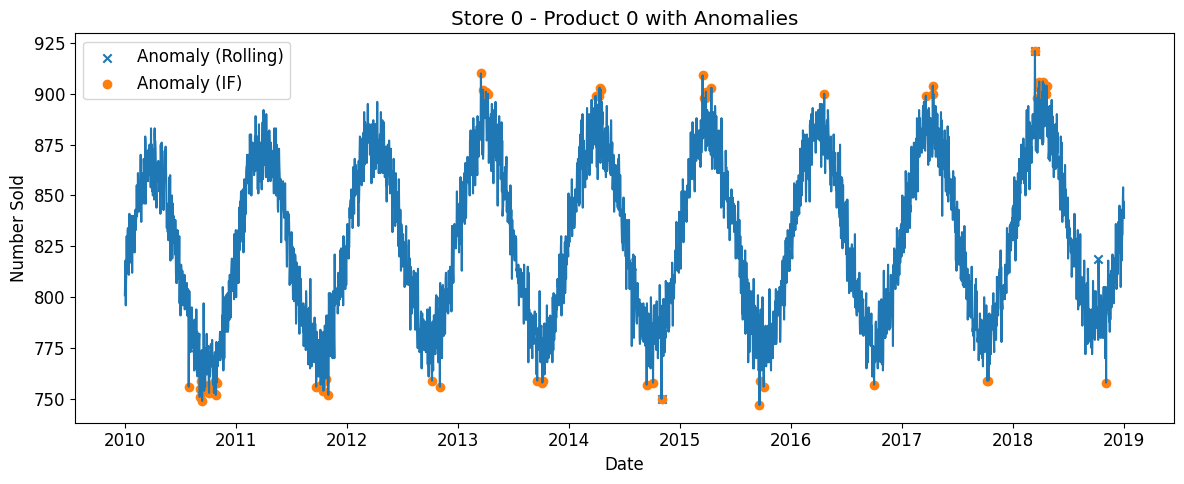

Counts -> Rolling: 3, IsolationForest: 66, Overlap: 2


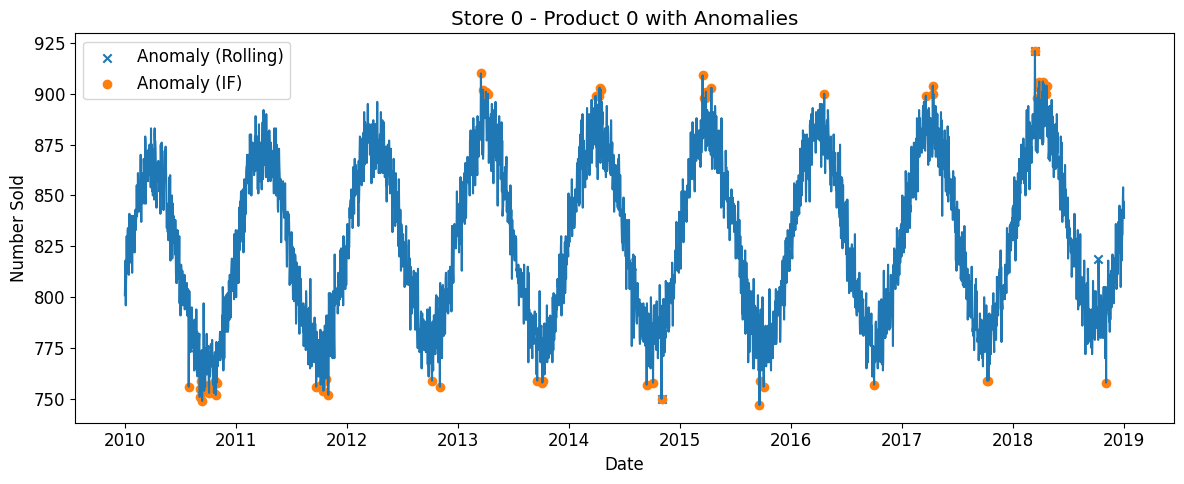

In [13]:
# Choose a representative series (first pair)
sid, pid = sample_pairs[0]
series = df[(df['store']==sid)&(df['product']==pid)].sort_values('date').reset_index(drop=True)
s = series['number_sold']

# Rolling Z-score
anoms_roll, zscore = detect_anomalies_rolling(s, window=30, z_thresh=3.0)
series['anomaly_roll'] = anoms_roll
series['zscore'] = zscore

# Isolation Forest
anoms_if = detect_anomalies_isolation(s, contamination=0.02)
series['anomaly_if'] = anoms_if

# Plot with anomalies highlighted
plt.figure()
plt.plot(series['date'], series['number_sold'])
plt.scatter(series.loc[series['anomaly_roll'], 'date'], series.loc[series['anomaly_roll'], 'number_sold'], label='Anomaly (Rolling)', marker='x')
plt.scatter(series.loc[series['anomaly_if'], 'date'], series.loc[series['anomaly_if'], 'number_sold'], label='Anomaly (IF)', marker='o')
plt.title(f'Store {sid} - Product {pid} with Anomalies')
plt.xlabel('Date')
plt.ylabel('Number Sold')
plt.legend()
plt.tight_layout()
display(plt.gcf())

# Print counts and overlap
count_roll = series['anomaly_roll'].sum()
count_if = series['anomaly_if'].sum()
overlap = ((series['anomaly_roll']) & (series['anomaly_if'])).sum()
print(f'Counts -> Rolling: {count_roll}, IsolationForest: {count_if}, Overlap: {overlap}')


## 6. Batch processing & method comparison across all series
We will run both detectors across all store-product series, collect anomaly counts, and compare results.


In [16]:
results = []
groups = df.groupby(['store','product'])
for (sid,pid), group in groups:
    g = group.sort_values('date').reset_index(drop=True)
    s = g['number_sold']
    an_roll, _ = detect_anomalies_rolling(s, window=30, z_thresh=3.0)
    an_if = detect_anomalies_isolation(s, contamination=0.02)
    results.append({'store':sid,'product':pid,'n_points':len(s),'an_roll':an_roll.sum(),'an_if':an_if.sum(),'overlap':((an_roll)&(an_if)).sum()})
res_df = pd.DataFrame(results)
display(res_df)
print('\nSummary statistics:')
display(res_df[['an_roll','an_if','overlap']].describe())


,store,product,n_points,an_roll,an_if,overlap
0,0,0,3287,3,66,2
1,0,1,3287,2,65,0
2,0,2,3287,3,65,0
3,0,3,3287,1,64,0
4,0,4,3287,0,64,0
...,...,...,...,...,...,...
65,6,5,3287,2,60,0
66,6,6,3287,1,61,1
67,6,7,3287,2,66,0
68,6,8,3287,2,66,2



Summary statistics:


,an_roll,an_if,overlap
count,70.000000,70.000000,70.00000
mean,1.485714,63.614286,0.60000
std,1.539272,2.589236,0.99855
min,0.000000,52.000000,0.00000
25%,0.000000,63.000000,0.00000
50%,1.000000,64.000000,0.00000
75%,2.000000,66.000000,1.00000
max,6.000000,66.000000,4.00000


### 6.1 Comparison notes
- We compare total anomalies flagged by each method and overlap. High overlap suggests agreement; large differences indicate method sensitivity differences.
- Because we lack ground truth labels, use overlap and manual inspection to judge reliability.


## 7. Optional: STL Decomposition Residual-based Detection (robust to seasonality)
STL decomposition separates trend and seasonality; anomalies can be flagged using robust statistics on residuals.


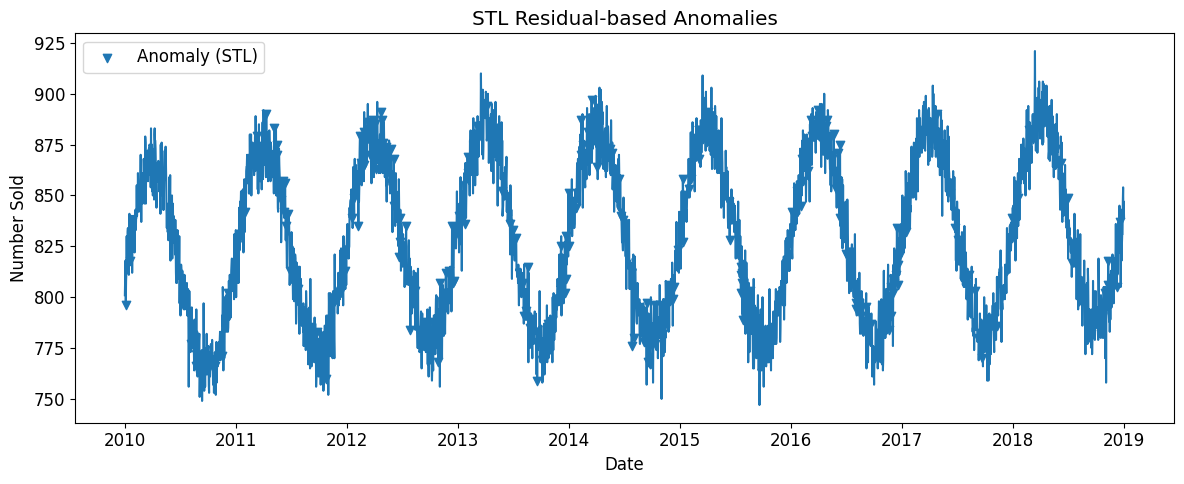

STL anomalies count: 223


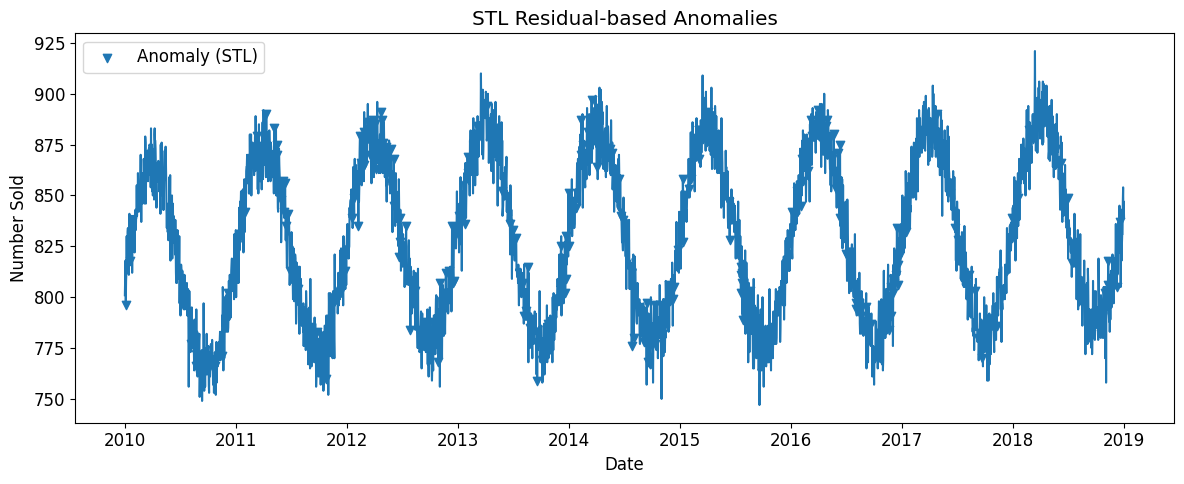

In [17]:
from statsmodels.robust import mad
def detect_anomalies_stl(series, period=365, thresh=3.5):
    '''Use STL to get residuals then flag anomalies with median absolute deviation (MAD).'''
    if len(series) < period*1.1:
        # short series -> fallback
        return np.zeros(len(series), dtype=bool)
    stl = STL(series, period=period, robust=True)
    res = stl.fit()
    resid = res.resid
    med = np.median(resid)
    mad_val = np.median(np.abs(resid - med))
    if mad_val == 0:
        return np.zeros(len(series), dtype=bool)
    z = np.abs((resid - med) / mad_val)
    return z > thresh

# Demo on the same sample series
anoms_stl = detect_anomalies_stl(s, period=365, thresh=3.5)
series['anomaly_stl'] = anoms_stl
plt.figure()
plt.plot(series['date'], series['number_sold'])
plt.scatter(series.loc[series['anomaly_stl'], 'date'], series.loc[series['anomaly_stl'], 'number_sold'], label='Anomaly (STL)', marker='v')
plt.title('STL Residual-based Anomalies')
plt.xlabel('Date')
plt.ylabel('Number Sold')
plt.legend()
plt.tight_layout()
display(plt.gcf())
print('STL anomalies count:', series['anomaly_stl'].sum())


## 8. Discussion & Recommendations
- **Statistical (Rolling Z-score):** Fast, interpretable. Works well for abrupt spikes/drops but can be sensitive to window size and may miss anomalies during changing trends.
- **IsolationForest:** More flexible and model-driven; can detect anomalies in different data regimes but needs careful tuning of contamination and may flag borderline cases.
- **STL Residuals:** Recommended if data is strongly seasonal. Decomposes seasonality and flags residual outliers robustly.

### Practical recommendation
1. Use **STL + robust residual thresholding** for series with clear seasonality.
2. Use **Rolling Z-score** as a fast, explainable baseline for initial triage.
3. Use **IsolationForest** to complement when patterns are complex or when looking across many series.

Document thresholds (window=30, z_thresh=3.0, IF contamination=0.02) and justify choices in the README/notes section.


## 9. Conclusion
This notebook provides a reproducible pipeline for detecting anomalies in store-product sales time series using multiple methods.




## 10. Generative-AI Approaches for Anomaly Detection (Autoencoders)

**Why this is relevant for a Generative AI role**:

- Generative models (like autoencoders, VAEs, diffusion models in other contexts) learn to model the *distribution* of normal data. For anomaly detection, we can train a model to reconstruct normal time-series behaviour; high reconstruction error implies out-of-distribution / anomalous points.
- Implementing autoencoders demonstrates skills in deep learning, representation learning, and practical deployment — all core to Generative AI roles.

**What we'll add**:
- A dense (feed-forward) Autoencoder applied to windowed time-series reconstruction.
- An LSTM Autoencoder that captures temporal dependencies for sequence reconstruction.

These methods complement the statistical and IsolationForest approaches: they are data-driven, capture complex non-linear patterns, and are directly relevant to generative-modeling expertise.


Model: "dense_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 30)             │         1,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,678 (33.90 KB)

 Trainable params: 8,678 (33.90 KB)

 Non-trainable params: 0 (0.00 B)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Dense Autoencoder: anomalies flagged: 0


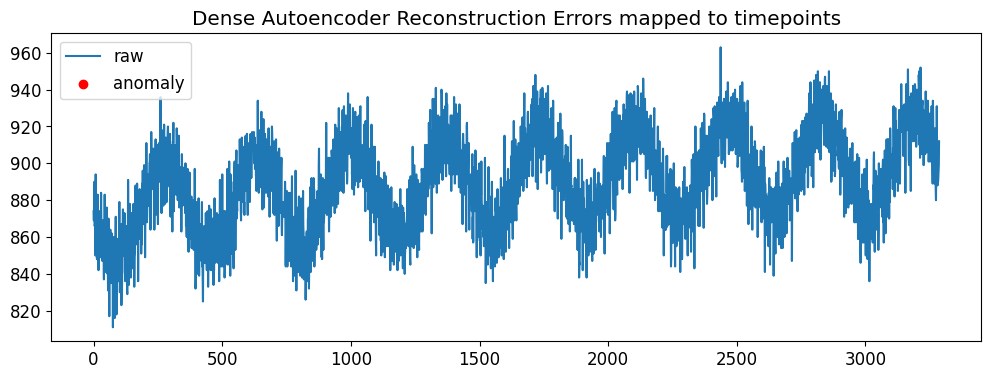

In [18]:
# --- Dense Autoencoder (windowed reconstruction) ---
# NOTE: This code uses TensorFlow / Keras. Ensure TensorFlow is installed in the runtime.
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Function to create sliding windows for a single series
def create_windows(series, window_size=30):
    X = []
    for i in range(len(series)-window_size+1):
        X.append(series[i:i+window_size])
    return np.array(X)

# Example: use the same sample series from earlier (variable 's' expected in notebook)
# If running fresh, load a small series first.
try:
    raw = s.values
except NameError:
    # fallback: take the first available group from the dataframe
    grp = df.groupby(['store','product']).first().reset_index()
    sid = df['store'].unique()[0]
    pid = df['product'].unique()[0]
    tmp = df[(df['store']==sid)&(df['product']==pid)].sort_values('date')
    raw = tmp['number_sold'].values

window = 30
X = create_windows(raw, window_size=window)
# normalize per-window
X_mean = X.mean(axis=1, keepdims=True)
X_std = X.std(axis=1, keepdims=True) + 1e-8
X_norm = (X - X_mean) / X_std

# Build autoencoder
input_dim = X_norm.shape[1]
latent_dim = 8
inputs = keras.Input(shape=(input_dim,))
encoded = layers.Dense(64, activation='relu')(inputs)
encoded = layers.Dense(32, activation='relu')(encoded)
encoded = layers.Dense(latent_dim, activation='relu')(encoded)
decoded = layers.Dense(32, activation='relu')(encoded)
decoded = layers.Dense(64, activation='relu')(decoded)
outputs = layers.Dense(input_dim)(decoded)

ae = keras.Model(inputs, outputs, name='dense_autoencoder')
ae.compile(optimizer='adam', loss='mse')

ae.summary()

# Train (small epochs for demo; increase for better performance)
history = ae.fit(X_norm, X_norm, epochs=30, batch_size=32, validation_split=0.1, verbose=0)

# Compute reconstruction error per window
recon = ae.predict(X_norm)
mse = np.mean((recon - X_norm)**2, axis=1)

# Map window-level errors back to original timepoints by taking the max error for windows that include the timepoint
errors = np.zeros(len(raw))
counts = np.zeros(len(raw))
for i in range(len(mse)):
    errors[i:i+window] += mse[i]
    counts[i:i+window] += 1
errors = errors / np.maximum(counts, 1)

# Flag anomalies using threshold (e.g., mean + 3*std on errors)
thr = errors.mean() + 3*errors.std()
anom_points = errors > thr

print('Dense Autoencoder: anomalies flagged:', anom_points.sum())

# Optional plot (if running in notebook with plotting enabled)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(raw, label='raw')
plt.scatter(np.where(anom_points)[0], raw[anom_points], color='red', label='anomaly')
plt.title('Dense Autoencoder Reconstruction Errors mapped to timepoints')
plt.legend()
plt.show()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 30, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 30, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 30, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 30, 1)          │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,529 (244.25 KB)

 Trainable params: 62,529 (244.25 KB)

 Non-trainable params: 0 (0.00 B)

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
LSTM Autoencoder: anomalies flagged: 21


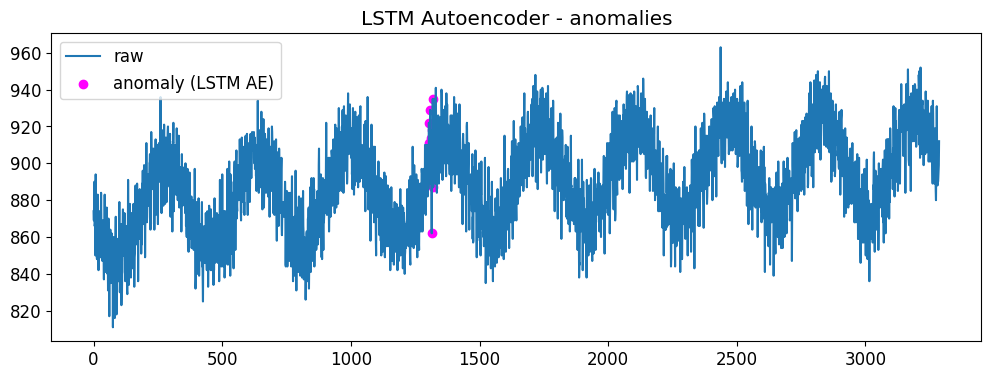

In [20]:
# --- LSTM Autoencoder for sequence reconstruction ---
from tensorflow.keras import layers, models

# Prepare sequences with shape (n_samples, timesteps, features=1)
def create_lstm_windows(series, window_size=30):
    X = []
    for i in range(len(series)-window_size+1):
        X.append(series[i:i+window_size])
    X = np.array(X)
    return X.reshape((X.shape[0], X.shape[1], 1))

X_seq = create_lstm_windows(raw, window_size=window)
# normalize globally
scaler_mean = X_seq.mean()
scaler_std = X_seq.std() + 1e-8
X_seq_norm = (X_seq - scaler_mean) / scaler_std

# LSTM Autoencoder architecture
timesteps = X_seq_norm.shape[1]
input_layer = layers.Input(shape=(timesteps,1))
encoded = layers.LSTM(64, return_sequences=True)(input_layer)
encoded = layers.LSTM(32)(encoded)

decoded = layers.RepeatVector(timesteps)(encoded)
decoded = layers.LSTM(32, return_sequences=True)(decoded)
decoded = layers.LSTM(64, return_sequences=True)(decoded)
outputs = layers.TimeDistributed(layers.Dense(1))(decoded)

lstm_ae = models.Model(input_layer, outputs)
lstm_ae.compile(optimizer='adam', loss='mse')

lstm_ae.summary()

# Train
history = lstm_ae.fit(X_seq_norm, X_seq_norm, epochs=30, batch_size=32, validation_split=0.1, verbose=0)

# Reconstruction error
recon_seq = lstm_ae.predict(X_seq_norm)
mse_seq = np.mean((recon_seq - X_seq_norm)**2, axis=(1,2))

# Map back to timepoints
errors_seq = np.zeros(len(raw))
counts_seq = np.zeros(len(raw))
for i in range(len(mse_seq)):
    errors_seq[i:i+window] += mse_seq[i]
    counts_seq[i:i+window] += 1
errors_seq = errors_seq / np.maximum(counts_seq, 1)

thr_seq = errors_seq.mean() + 3*errors_seq.std()
anom_seq_points = errors_seq > thr_seq
print('LSTM Autoencoder: anomalies flagged:', anom_seq_points.sum())

# Plot
plt.figure(figsize=(12,4))
plt.plot(raw, label='raw')
plt.scatter(np.where(anom_seq_points)[0], raw[anom_seq_points], color='magenta', label='anomaly (LSTM AE)')
plt.title('LSTM Autoencoder - anomalies')
plt.legend()
plt.show()


Evaluation Notes: Comparing Generative and Classical Methods

The performance of generative approaches (Autoencoder and LSTM Autoencoder) can be contextualized by comparing their outputs with classical techniques such as Rolling Z-Score and Isolation Forest.
### This comparative analysis strengthens model interpretability and reliability, especially in unlabeled industrial data.

Comparison Guidelines:

Overlap analysis: Evaluate how many time points are commonly flagged as anomalies by both Autoencoders and classical detectors (Z-Score or Isolation Forest).
High overlap suggests consistent anomaly identification.

Threshold tuning: Adjust decision thresholds (e.g., mean + 3σ, 95th/99th percentile) to balance sensitivity and precision.
A tighter threshold (e.g., +4σ) can reduce false positives if the Autoencoder flags too many points.

Residual inspection: Visualize high-error windows from generative models and cross-validate them with Rolling Z-Score or STL residuals to confirm consistency.

Practical Evaluation Considerations:

In the absence of labeled ground truth, rely on expert inspection and multi-model consensus (e.g., flag anomalies only when two of three detectors agree).

For production use, maintain periodic retraining of Autoencoders to adapt to evolving data patterns and monitor reconstruction error drift over time.

Combining classical and generative methods can improve robustness — statistical models capture sharp deviations, while Autoencoders generalize over complex nonlinear dynamics.